<a href="https://colab.research.google.com/github/shivammehta007/QuestionGenerator/blob/master/Classifier_to_detect_type_of_questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing Classifier Model

In [1]:
# Essential Installation for working of notebook
!pip install -U tqdm

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.44.1)


### Imports

In [0]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from tqdm.auto import tqdm, trange
from wordcloud import WordCloud
from xgboost import XGBClassifier

### Environment Setup 

In [0]:
SEED=1234
def seed_all(seed=1234):
    """Seed the results for duplication"""
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_all(SEED)

In [0]:
tqdm.pandas()
nlp = spacy.load("en_core_web_sm") 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
DATASET_LOCATION = '/content/drive/My Drive/Data/GrammarDataset.csv'

## Dataset Overview

In [0]:
original_dataset = pd.read_csv(DATASET_LOCATION, sep="\t")

In [8]:
original_dataset.head()

,Question,key,answer,Type of Question,Sub Section
0,She _________________ some chocolates to the p...,bring,She brought some chocolates to the party.,irregular verb,past simple
1,I _________________ a new song on the radio.,hear,I heard a new song on the radio.,irregular verb,past simple
2,I _________________ three books last week.,read,I read three books last week.,irregular verb,past simple
3,They _________________ French to the waitress.,speak,They spoke French to the waitress.,irregular verb,past simple
4,He _________________ during the class but now ...,understand,He understood during the class but now he doe...,irregular verb,past simple


In [9]:
original_dataset.dtypes

Question            object
key                 object
answer              object
Type of Question    object
Sub Section         object
dtype: object

#### EDA

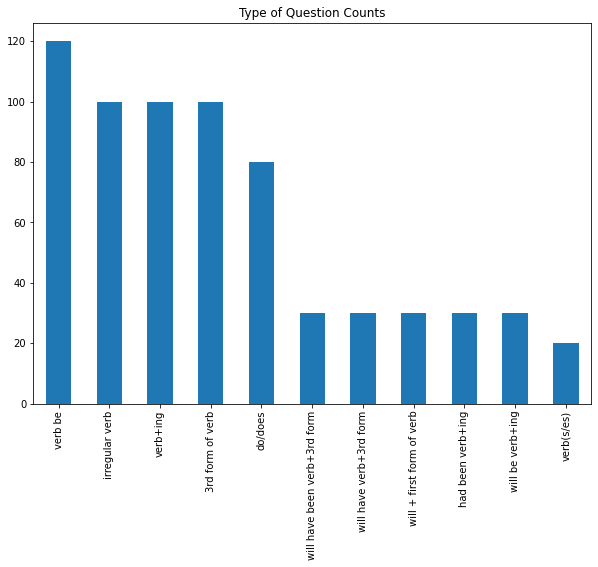

In [10]:
ax, fig = plt.subplots(figsize=(10, 7))
question_class = original_dataset["Type of Question"].value_counts()
question_class.plot(kind='bar')
plt.title('Type of Question Counts')
plt.show()

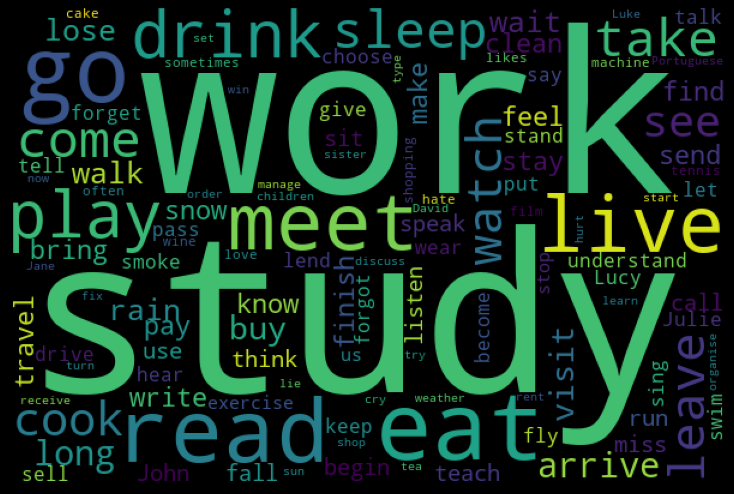

In [11]:
insincere_wordcloud = WordCloud(width=600, height=400).generate(" ".join(original_dataset["key"]))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(insincere_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### PreProcessing

In [0]:
def preprocessor(dataset):
    # Replace continuous underscores with single one
    dataset["Question"] = dataset["Question"].str.replace("[_]{2,}", "_")
    # Remove Brackets
    dataset["Question"] = dataset["Question"].str.replace("[\)\(]", "")
    # Strip whitespaces
    dataset["Question"] = dataset["Question"].apply(lambda x: x.strip())
    # Convert all text to lowercase
    for columns in dataset.columns:
        dataset[columns] = dataset[columns].str.lower() 

    return dataset

In [0]:
original_dataset = preprocessor(original_dataset)

In [14]:
original_dataset.columns

Index(['Question', 'key', 'answer', 'Type of Question', 'Sub Section'], dtype='object')

#### Encoding Labels

In [0]:
label_encoder = LabelEncoder()
original_dataset["Type of Question"] = label_encoder.fit_transform(original_dataset["Type of Question"])

#### Split Training and Testing Data

In [0]:
X_train_orig_dataset, X_test_orig_dataset, y_train_orig_dataset, y_test_orig_dataset = train_test_split(original_dataset[["Question", "key", "answer"]], original_dataset["Type of Question"], random_state=SEED, test_size=0.15)

In [17]:
X_train_orig_dataset.shape, X_test_orig_dataset.shape, y_train_orig_dataset.shape, y_test_orig_dataset.shape

((569, 3), (101, 3), (569,), (101,))

## Experiments:

In [18]:
X_train_orig_dataset.head()

,Question,key,answer
271,how / they / get to work?,they,how do they get to work?
488,we were late for the plane because we _our pas...,forgot,we were late for the plane because we had forg...
131,we _ thirsty.,be,we aren't thirsty.
643,"he_, so the kitchen will be warm.",cook,"he will have been cooking, so the kitchen will..."
155,you / in a cafe?,be,are you in a cafe?


### Experimentation Setup

#### Models

In [0]:
text_vectorizers = [
                    ('CountVectorizer', CountVectorizer(tokenizer=lambda x: x.split())), 
                    ('TfIdFVectorize', TfidfVectorizer(tokenizer=lambda x: x.split()))
                ]
classifiers = [
               ('MultiNomial Naive Bais', MultinomialNB(alpha=0.1)),
               ('LogisticRegression', LogisticRegression(max_iter=5000)), 
               ('SVM', SVC()), ('RandomForest', RandomForestClassifier()), 
               ('XGBClassifier', XGBClassifier(random_state=SEED, learning_rate=0.01))
            ]

In [0]:
def check_classification(X_train, y_train, X_test, y_test):

    # Result DataFrame
    result_dataframe = pd.DataFrame({
        'Vectorizer': [name for name, model in text_vectorizers]
        }, columns = ['Vectorizer'] + [name for name, model in classifiers])
    result_dataframe.set_index('Vectorizer', inplace=True)


    best_score = 0
    best_model = None
    best_pipe = None
    for classifier_name, classifier in classifiers:
        for text_vectorizer_name, text_vectorizer in text_vectorizers:
            pipe = Pipeline(steps=[
                                ('text_vec', text_vectorizer),
                                ('class', classifier)
            ])
            pipe.fit(X_train, y_train)
            f1_measure = f1_score(pipe.predict(X_test), y_test, average='micro')
            # print('Model : {} -> {}:  accuracy: {:.4f}'.format(text_vectorizer_name, classifier_name, acc*100))
            result_dataframe[classifier_name][text_vectorizer_name] = '{:.4f}'.format(f1_measure)

            if f1_measure > best_score:
                best_score = f1_measure
                best_pipe = pipe
                best_model = '{} -> {}'.format(text_vectorizer_name, classifier_name)
    # TODO: Remove while actually writing the code Code for Debugging
    # analyzer = best_pipe['text_vec'].build_analyzer()
    # print(analyzer("i _ the steak for dinner.  choose  i chose the steak for dinner."))
    # print(analyzer("words#i _ words#_ words#the words#steak words#for words#dinner words#. words#  words#choose words#  words#i words#chose words#the words#steak words#for words#dinner words#."))
    # with np.printoptions(threshold=np.inf):
    #     print("First: {}".format(best_pipe['text_vec'].transform(["i _ the steak for dinner.  choose  i chose the steak for dinner."])[0]))
    #     print("Second: {}".format(best_pipe['text_vec'].transform(["words#i words#_ words#the words#steak words#for words#dinner words#. words#  words#choose words#  words#i words#chose words#the words#steak words#for words#dinner words#."])[0]))


    print("\n\nBest F1 Measure was: {:.4f} with the Model: {}".format(best_score, best_model))
    return result_dataframe

#### Result Placeholder

In [0]:
result_dataframe = pd.DataFrame({
        'Vectorizer': [name for name, model in text_vectorizers]
        }, columns = ['Vectorizer'] + [name for name, model in classifiers])
result_dataframe.set_index('Vectorizer', inplace=True)

results = []

#### N-Gram Generator

In [69]:
from itertools import cycle
from collections import deque

def ngrams(sentence, n=2):
    words = [word.text for word in nlp(sentence)]
    d = deque(maxlen=n)
    d.extend(words[:n])
    words = words[n:]
    results = []
    for window, word in zip(cycle((d,)), words):
        results.append([ngram for ngram in window])
        d.append(word)
    results.append([ngram for ngram in d])

    return results

ngrams("this sentence is a test sentence to check ngrams")

[['this', 'sentence'],
 ['sentence', 'is'],
 ['is', 'a'],
 ['a', 'test'],
 ['test', 'sentence'],
 ['sentence', 'to'],
 ['to', 'check'],
 ['check', 'ngrams']]

In [67]:
for n in range(2,5):
    print(" {}-Grams:".format(n), end=" ")
    print(ngrams("Hello World! This is a test example of N-Gram generator", n))

 2-Grams: [['Hello', 'World'], ['World', '!'], ['!', 'This'], ['This', 'is'], ['is', 'a'], ['a', 'test'], ['test', 'example'], ['example', 'of'], ['of', 'N'], ['N', '-'], ['-', 'Gram'], ['Gram', 'generator']]
 3-Grams: [['Hello', 'World', '!'], ['World', '!', 'This'], ['!', 'This', 'is'], ['This', 'is', 'a'], ['is', 'a', 'test'], ['a', 'test', 'example'], ['test', 'example', 'of'], ['example', 'of', 'N'], ['of', 'N', '-'], ['N', '-', 'Gram'], ['-', 'Gram', 'generator']]
 4-Grams: [['Hello', 'World', '!', 'This'], ['World', '!', 'This', 'is'], ['!', 'This', 'is', 'a'], ['This', 'is', 'a', 'test'], ['is', 'a', 'test', 'example'], ['a', 'test', 'example', 'of'], ['test', 'example', 'of', 'N'], ['example', 'of', 'N', '-'], ['of', 'N', '-', 'Gram'], ['N', '-', 'Gram', 'generator']]


#### Sample Generator

In [0]:
def get_input_samples(X, y, n=5):
    results = []
    for i in random.sample(range(len(X) - 1), n):
        results.append("{} --> {} ".format(X.iloc[i], label_encoder.inverse_transform([y.iloc[i]])))

    return results

### Experiment 1:  Word#\$\{$words_i$\}
Concatenating Question + key + answer in a Bag Of Words Approach \\
No Feature Engineering

In [0]:
experiment_text = "Concatenating question + key + answer. like word#word_i"

#### Preprocessing

In [0]:
X_train = X_train_orig_dataset["Question"] + " " + X_train_orig_dataset["key"] + " " + X_train_orig_dataset["answer"]
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"] + " " + X_test_orig_dataset["key"] + " " + X_test_orig_dataset["answer"]
y_test = y_test_orig_dataset

In [28]:
def add_word_template(text):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("words#{}".format(token.text))

    return " ".join(text)

add_word_template("i _ the steak for dinner.  choose  i chose the steak for dinner.")

'words#i words#_ words#the words#steak words#for words#dinner words#. words#  words#choose words#  words#i words#chose words#the words#steak words#for words#dinner words#.'

In [29]:
X_train = X_train.progress_apply(add_word_template)
X_test = X_test.progress_apply(add_word_template)

#### Input Samples

In [30]:
get_input_samples(X_train, y_train)

["words#they words#_ words#so words#we words#went words#to words#a words#restaurant words#. words#not words#eat words#they words#had words#n't words#eaten words#so words#we words#went words#to words#a words#restaurant words#. --> ['3rd form of verb'] ",
 "words#when words#/ words#you words#/ words#leave words#? words#you words#leave words#when words#are words#you words#leaving words#? --> ['verb+ing'] ",
 "words#they words#/ words#live words#in words#london words#live words#they words#live words#in words#london words#. --> ['verb(s/es)'] ",
 "words#_ words#football words#when words#he words#was words#injured words#? words#how words#long words#he words#play words#how words#long words#had words#he words#been words#playing words#football words#when words#he words#was words#injured words#? --> ['had been verb+ing'] ",
 "words#_ words#the words#film words#already words#? words#she words#see words#had words#she words#seen words#the words#film words#already words#? --> ['3rd form of verb'] "]

#### Experimentation Results

In [31]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result

# First:   (0, 24)	1
#   (0, 193)	1
#   (0, 194)	1
#   (0, 257)	2
#   (0, 356)	2
#   (0, 447)	2
#   (0, 851)	2
#   (0, 912)	2
# Second:   (0, 24)



Best F1 Measure was: 0.9703 with the Model: CountVectorizer -> RandomForest


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7327,0.8812,0.7822,0.9703,0.9703
TfIdFVectorize,0.6832,0.7228,0.6733,0.9307,0.9406


### Experiment 2: word_pos#\$\{$word_i$\}_\$\{$pos_i$\}
With Word and POS tags, token.tag_ gives a detailed POS tag where we can distinguish between forms of verb. \\
More Information https://spacy.io/api/annotation#pos-tagging about the tags

In [0]:
experiment_text = "Adding Pos Tags along with word word_pos#{word_i}_{pos_i} + k#tags + a#tags Unigrams"

#### Preprocessing

In [0]:
X_train = X_train_orig_dataset["Question"] + " " + X_train_orig_dataset["key"] + " " + X_train_orig_dataset["answer"]
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"] + " " + X_test_orig_dataset["key"] + " " + X_test_orig_dataset["answer"]
y_test = y_test_orig_dataset

In [35]:
def add_word_pos_template(text):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("word_pos#{}_{}".format(token.text, token.tag_))

    return " ".join(text)

# Testing method
test_sentence = "Testing the Pos Tagger in this sentence let's see how it works!".lower()
add_word_pos_template(test_sentence)

"word_pos#testing_VBG word_pos#the_DT word_pos#pos_NN word_pos#tagger_NN word_pos#in_IN word_pos#this_DT word_pos#sentence_NN word_pos#let_VB word_pos#'s_PRP word_pos#see_VB word_pos#how_WRB word_pos#it_PRP word_pos#works_VBZ word_pos#!_."

In [39]:
X_train = X_train.progress_apply(add_word_pos_template)
X_test = X_test.progress_apply(add_word_pos_template)

#### Input Samples

In [40]:
get_input_samples(X_train, y_train)

["word_pos#what_WP word_pos#__NNP word_pos#by_IN word_pos#the_DT word_pos#end_NN word_pos#of_IN word_pos#the_DT word_pos#day_NN word_pos#?_. word_pos#you_PRP word_pos#do_VBP word_pos#what_WP word_pos#will_MD word_pos#you_PRP word_pos#have_VB word_pos#done_VBN word_pos#by_IN word_pos#the_DT word_pos#end_NN word_pos#of_IN word_pos#the_DT word_pos#day_NN word_pos#?_. --> ['will have verb+3rd form'] ",
 "word_pos#i_PRP word_pos#/_: word_pos#not_RB word_pos#/_SYM word_pos#like_UH word_pos#coffee_NN word_pos#not_RB word_pos#i_PRP word_pos#do_VBP word_pos#n't_RB word_pos#like_VB word_pos#coffee_NN word_pos#._. --> ['do/does'] ",
 "word_pos#who_WP word_pos#/_NFP word_pos#the_DT word_pos#teacher_NN word_pos#/_, word_pos#be_VB word_pos#?_. word_pos#be_VB word_pos#who_WP word_pos#was_VBD word_pos#the_DT word_pos#teacher_NN word_pos#?_. --> ['verb be'] ",
 "word_pos#what_WDT word_pos#time_NN word_pos#__NNP word_pos#today_NN word_pos#?_. word_pos#the_DT word_pos#sun_NN word_pos#set_VBD word_pos#wha

#### Experimentation Results

In [41]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.9802 with the Model: CountVectorizer -> RandomForest


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7228,0.8614,0.7525,0.9802,0.9406
TfIdFVectorize,0.6733,0.7327,0.7129,0.9010,0.8812


### Experiment 3: pos#\$\{$pos_i$\} 
With just POS

In [0]:
experiment_text = "Classifying based on POS tags pos#{pos_i}"

#### Preprocessing

In [0]:
X_train = X_train_orig_dataset["Question"] + " " + X_train_orig_dataset["key"] + " " + X_train_orig_dataset["answer"]
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"] + " " + X_test_orig_dataset["key"] + " " + X_test_orig_dataset["answer"]
y_test = y_test_orig_dataset

In [44]:
def add_pos_template(text):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("pos#{}".format(token.tag_))

    return " ".join(text)

# Testing method
test_sentence = "Testing the Pos Tagger in this sentence let's see how it works!".lower()
add_pos_template(test_sentence)

'pos#VBG pos#DT pos#NN pos#NN pos#IN pos#DT pos#NN pos#VB pos#PRP pos#VB pos#WRB pos#PRP pos#VBZ pos#.'

In [45]:
X_train = X_train.progress_apply(add_pos_template)
X_test = X_test.progress_apply(add_pos_template)

#### Input Samples

In [46]:
get_input_samples(X_train, y_train)

["pos#NNP pos#NNP pos#NNP pos#, pos#RB pos#SYM pos#NN pos#IN pos#DT pos#NN pos#WRB pos#DT pos#NN pos#VBD pos#RB pos#VB pos#NNP pos#NNP pos#NNP pos#VBD pos#RB pos#VBG pos#IN pos#DT pos#NN pos#. --> ['verb+ing'] ",
 "pos#PRP pos#VBD pos#PRP pos#IN pos#PRP pos#NNP pos#DT pos#NN pos#IN pos#DT pos#NN pos#. pos#VB pos#PRP pos#VBD pos#PRP pos#IN pos#PRP pos#VBD pos#VBN pos#DT pos#NN pos#IN pos#DT pos#NN pos#. --> ['3rd form of verb'] ",
 "pos#NNP pos#, pos#RB pos#SYM pos#VB pos#: pos#PRP$ pos#NN pos#RB pos#VB pos#NNP pos#VBZ pos#RB pos#VBN pos#PRP$ pos#NN pos#. --> ['3rd form of verb'] ",
 "pos#PRP pos#VBD pos#IN pos#PRP pos#NNP pos#DT pos#NNP pos#RB pos#. pos#RB pos#VB pos#PRP pos#VBD pos#IN pos#PRP pos#VBD pos#RB pos#VBN pos#DT pos#NNP pos#RB pos#. --> ['3rd form of verb'] ",
 "pos#NNP pos#CC pos#NNP pos#, pos#RB pos#VBP pos#IN pos#NNS pos#RB pos#NNP pos#CC pos#NNP pos#RB pos#VBP pos#IN pos#NNS pos#. --> ['verb(s/es)'] "]

#### Experimentation Results

In [47]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.9208 with the Model: CountVectorizer -> RandomForest


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.6238,0.8218,0.7624,0.9208,0.8713
TfIdFVectorize,0.6634,0.6832,0.7129,0.8614,0.7822


### Experiment 4: word\_tag#\${$word_i$}_\${$( q, k, a )$}
With Question, Key, Answer Tagging

In [0]:
experiment_text = "Tagging word with q, k, a example: word_tag#{word_i}_{q/k/a}"

#### Preprocessing

In [49]:
def add_word_tag_template(text, tag):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("word_tag#{}_{}".format(token.text, tag))
    
    return " ".join(text)

add_word_tag_template("test sentence", "q")

'word_tag#test_q word_tag#sentence_q'

In [0]:
X_train = X_train_orig_dataset["Question"].apply(lambda x: add_word_tag_template(x, "q")) + " " + X_train_orig_dataset["key"].apply(lambda x: add_word_tag_template(x, "k")) + " " + X_train_orig_dataset["answer"].apply(lambda x: add_word_tag_template(x, "a"))
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"].apply(lambda x: add_word_tag_template(x, "q")) + " " + X_test_orig_dataset["key"].apply(lambda x: add_word_tag_template(x, "k")) + " " + X_test_orig_dataset["answer"].apply(lambda x: add_word_tag_template(x, "a"))
y_test = y_test_orig_dataset

#### Input Samples

In [51]:
get_input_samples(X_train, y_train)

["word_tag#we_q word_tag#/_q word_tag#not_q word_tag#/_q word_tag#watch_q word_tag#tv_q word_tag#at_q word_tag#the_q word_tag#moment_q word_tag#not_k word_tag#watch_k word_tag#we_a word_tag#are_a word_tag#n't_a word_tag#watching_a word_tag#tv_a word_tag#at_a word_tag#the_a word_tag#moment_a word_tag#._a --> ['verb+ing'] ",
 "word_tag#they_q word_tag#/_q word_tag#not_q word_tag#/_q word_tag#have_q word_tag#a_q word_tag#car_q word_tag#not_k word_tag#they_a word_tag#do_a word_tag#n't_a word_tag#have_a word_tag#a_a word_tag#car_a word_tag#._a --> ['do/does'] ",
 "word_tag#john_q word_tag#/_q word_tag#come_q word_tag#from_q word_tag#new_q word_tag#zealand_q word_tag#?_q word_tag#come_k word_tag#does_a word_tag#john_a word_tag#come_a word_tag#from_a word_tag#new_a word_tag#zealand_a word_tag#?_a --> ['do/does'] ",
 "word_tag#the_q word_tag#house_q word_tag#has_q word_tag#been_q word_tag#__q word_tag#._q word_tag#sell_k word_tag#the_a word_tag#house_a word_tag#has_a word_tag#been_a word_tag#s

#### Experimentation Results

In [52]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.9802 with the Model: CountVectorizer -> XGBClassifier


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.8119,0.9505,0.8812,0.9604,0.9802
TfIdFVectorize,0.7525,0.8713,0.8317,0.8812,0.9505


### Experiment 4: word_pos_tag#\${$word_i$}_\${$pos_i$}_{(q, k, a)}
POS Tagger with q,k,a tagging

In [0]:
experiment_text = "Adding POS Tagging and qka tagging example: word_pos_tag#{word_i}_{pos_i}_{(q, k, a)}"

#### Preprocessing

In [54]:
def add_word_pos_tag_template(text, tag):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("word_pos_tag#{}_{}_{}".format(token.text, token.tag_, tag))

    return " ".join(text)

add_word_pos_tag_template("this is test example", "a")

'word_pos_tag#this_DT_a word_pos_tag#is_VBZ_a word_pos_tag#test_NN_a word_pos_tag#example_NN_a'

In [0]:
X_train = X_train_orig_dataset["Question"].apply(lambda x: add_word_pos_tag_template(x, "q")) + " " + X_train_orig_dataset["key"].apply(lambda x: add_word_pos_tag_template(x, "k")) + " " + X_train_orig_dataset["answer"].apply(lambda x: add_word_pos_tag_template(x, "a"))
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"].apply(lambda x: add_word_pos_tag_template(x, "q")) + " " + X_test_orig_dataset["key"].apply(lambda x: add_word_pos_tag_template(x, "k")) + " " + X_test_orig_dataset["answer"].apply(lambda x: add_word_pos_tag_template(x, "a"))
y_test = y_test_orig_dataset

#### Input Samples

In [56]:
get_input_samples(X_train, y_train)

["word_pos_tag#i_PRP_q word_pos_tag#__NNP_q word_pos_tag#a_DT_q word_pos_tag#new_JJ_q word_pos_tag#song_NN_q word_pos_tag#on_IN_q word_pos_tag#the_DT_q word_pos_tag#radio_NN_q word_pos_tag#._._q word_pos_tag# __SP_k word_pos_tag#hear_NNP_k word_pos_tag# __SP_a word_pos_tag#i_PRP_a word_pos_tag#heard_VBD_a word_pos_tag#a_DT_a word_pos_tag#new_JJ_a word_pos_tag#song_NN_a word_pos_tag#on_IN_a word_pos_tag#the_DT_a word_pos_tag#radio_NN_a word_pos_tag#._._a --> ['irregular verb'] ",
 "word_pos_tag#i_PRP_q word_pos_tag#'d_MD_q word_pos_tag#__NNP_q word_pos_tag#a_DT_q word_pos_tag#lovely_JJ_q word_pos_tag#new_JJ_q word_pos_tag#bike_NN_q word_pos_tag#for_IN_q word_pos_tag#my_PRP$_q word_pos_tag#birthday_NN_q word_pos_tag#,_,_q word_pos_tag#so_CC_q word_pos_tag#i_PRP_q word_pos_tag#was_VBD_q word_pos_tag#keen_JJ_q word_pos_tag#to_TO_q word_pos_tag#try_VB_q word_pos_tag#it_PRP_q word_pos_tag#._._q word_pos_tag#get_VB_k word_pos_tag#i_PRP_a word_pos_tag#'d_MD_a word_pos_tag#got_VBN_a word_pos_ta

#### Experimentation Results

In [57]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.9307 with the Model: CountVectorizer -> LogisticRegression


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.8119,0.9307,0.8614,0.9307,0.9307
TfIdFVectorize,0.7822,0.8416,0.8218,0.8515,0.9307


### Experiment 5: word#{$word_i$} word_pos_tag#\${$word_i$}_\${$pos_i$}_{(q, k, a)}

In [0]:
experiment_text = "Combining word and word_pos_tags"

#### Preprocessing

In [59]:
def add_word_and_word_pos_tag_template(text, tag):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("word#{} word_pos_tag##{}_{}_{}".format(token.text, token.text, token.tag_, tag))

    return " ".join(text)

add_word_and_word_pos_tag_template("This is a test sentence! We will see the difference between playing and played", "q")

'word#This word_pos_tag##This_DT_q word#is word_pos_tag##is_VBZ_q word#a word_pos_tag##a_DT_q word#test word_pos_tag##test_NN_q word#sentence word_pos_tag##sentence_NN_q word#! word_pos_tag##!_._q word#We word_pos_tag##We_PRP_q word#will word_pos_tag##will_MD_q word#see word_pos_tag##see_VB_q word#the word_pos_tag##the_DT_q word#difference word_pos_tag##difference_NN_q word#between word_pos_tag##between_IN_q word#playing word_pos_tag##playing_VBG_q word#and word_pos_tag##and_CC_q word#played word_pos_tag##played_VBD_q'

In [0]:
X_train = X_train_orig_dataset["Question"].apply(lambda x: add_word_and_word_pos_tag_template(x, "q")) + " " + X_train_orig_dataset["key"].apply(lambda x: add_word_and_word_pos_tag_template(x, "k")) + " " + X_train_orig_dataset["answer"].apply(lambda x: add_word_and_word_pos_tag_template(x, "a"))
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"].apply(lambda x: add_word_and_word_pos_tag_template(x, "q")) + " " + X_test_orig_dataset["key"].apply(lambda x: add_word_and_word_pos_tag_template(x, "k")) + " " + X_test_orig_dataset["answer"].apply(lambda x: add_word_and_word_pos_tag_template(x, "a"))
y_test = y_test_orig_dataset

#### Input Samples

In [62]:
get_input_samples(X_train, y_train)

["word#it word_pos_tag##it_PRP_q word#_ word_pos_tag##__NNP_q word#cold word_pos_tag##cold_JJ_q word#last word_pos_tag##last_JJ_q word#night word_pos_tag##night_NN_q word#. word_pos_tag##._._q word#be word_pos_tag##be_VB_k word#it word_pos_tag##it_PRP_a word#was word_pos_tag##was_VBD_a word#cold word_pos_tag##cold_JJ_a word#last word_pos_tag##last_JJ_a word#night word_pos_tag##night_NN_a word#. word_pos_tag##._._a --> ['irregular verb'] ",
 "word#he word_pos_tag##he_PRP_q word#_ word_pos_tag##__NNP_q word#in word_pos_tag##in_IN_q word#the word_pos_tag##the_DT_q word#library word_pos_tag##library_NN_q word#. word_pos_tag##._._q word#study word_pos_tag##study_NN_k word#he word_pos_tag##he_PRP_a word#will word_pos_tag##will_MD_a word#be word_pos_tag##be_VB_a word#studying word_pos_tag##studying_VBG_a word#in word_pos_tag##in_IN_a word#the word_pos_tag##the_DT_a word#library word_pos_tag##library_NN_a word#. word_pos_tag##._._a --> ['will be verb+ing'] ",
 "word#he word_pos_tag##he_PRP_q w

#### Experimentation Results

In [63]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.9703 with the Model: CountVectorizer -> XGBClassifier


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7525,0.9307,0.8416,0.9505,0.9703
TfIdFVectorize,0.7129,0.8020,0.7723,0.8911,0.9208


### Experiment 6: bigram#{$word_i$}_{$word_{i+1}$}

In [0]:
experiment_text = "Adding bigrams of words bigram#{word_i}_{word_i+1}"

#### Preprocessing

In [73]:
def add_ngram_template(text, n=2):
    tokens = ngrams(text, n)
    text = []
    for token in tokens:
        text.append("ngram#{}".format("_".join(token)))

    return " ".join(text)

add_bigram_template("This is a test sentence! We will see the difference between playing and played")

'bigram#This_is bigram#is_a bigram#a_test bigram#test_sentence bigram#sentence_! bigram#!_We bigram#We_will bigram#will_see bigram#see_the bigram#the_difference bigram#difference_between bigram#between_playing bigram#playing_and bigram#and_played'

In [0]:
X_train = X_train_orig_dataset["Question"].apply(lambda x: add_ngram_template(x)) + " " + X_train_orig_dataset["key"].apply(lambda x: add_ngram_template(x)) + " " + X_train_orig_dataset["answer"].apply(lambda x: add_ngram_template(x))
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"].apply(lambda x: add_ngram_template(x)) + " " + X_test_orig_dataset["key"].apply(lambda x: add_ngram_template(x)) + " " + X_test_orig_dataset["answer"].apply(lambda x: add_ngram_template(x))
y_test = y_test_orig_dataset

#### Input Samples

In [75]:
get_input_samples(X_train, y_train)

["ngram#the_maid ngram#maid_/ ngram#/_not ngram#not_/ ngram#/_clean ngram#clean_the ngram#the_bedrooms ngram#bedrooms_when ngram#when_the ngram#the_murder ngram#murder_happened ngram#not_clean ngram#the_maid ngram#maid_was ngram#was_n't ngram#n't_cleaning ngram#cleaning_the ngram#the_bedrooms ngram#bedrooms_. --> ['verb+ing'] ",
 "ngram#john_/ ngram#/_come ngram#come_from ngram#from_new ngram#new_zealand ngram#zealand_? ngram#come ngram#does_john ngram#john_come ngram#come_from ngram#from_new ngram#new_zealand ngram#zealand_? --> ['do/does'] ",
 "ngram#you_/ ngram#/_come ngram#come_? ngram#come ngram#are_you ngram#you_coming ngram#coming_? --> ['verb+ing'] ",
 "ngram#john__ ngram#__lucy ngram#lucy_. ngram#meet ngram#john_will ngram#will_have ngram#have_met ngram#met_lucy ngram#lucy_. --> ['will have verb+3rd form'] ",
 "ngram#you__ ngram#__from ngram#from_china ngram#china_. ngram#be ngram#you_are ngram#are_n't ngram#n't_from ngram#from_china ngram#china_. --> ['verb be'] "]

#### Experimentation Results

In [76]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.8119 with the Model: TfIdFVectorize -> RandomForest


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.6931,0.7723,0.6040,0.7921,0.6535
TfIdFVectorize,0.6634,0.6139,0.5743,0.8119,0.7129


# Results

In [77]:
from IPython.display import display, HTML

for i, (description, result) in enumerate(results):
    print("Experiment {}:".format(i+1))
    print(description)
    display(HTML(result.to_html()))
    print("\n\n")

Experiment 1:
Concatenating question + key + answer. like word#word_i


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7327,0.8812,0.7822,0.9703,0.9703
TfIdFVectorize,0.6832,0.7228,0.6733,0.9307,0.9406





Experiment 2:
Adding Pos Tags along with word word_pos#{word_i}_{pos_i} + k#tags + a#tags Unigrams


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7129,0.8713,0.6832,0.9505,0.9307
TfIdFVectorize,0.6040,0.7228,0.6238,0.9406,0.8515





Experiment 3:
Classifying based on POS tags pos#{pos_i}


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7228,0.8614,0.7525,0.9802,0.9406
TfIdFVectorize,0.6733,0.7327,0.7129,0.9010,0.8812





Experiment 4:
Classifying based on POS tags pos#{pos_i}


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.6238,0.8218,0.7624,0.9208,0.8713
TfIdFVectorize,0.6634,0.6832,0.7129,0.8614,0.7822





Experiment 5:
Tagging word with q, k, a example: word_tag#{word_i}_{q/k/a}


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.8119,0.9505,0.8812,0.9604,0.9802
TfIdFVectorize,0.7525,0.8713,0.8317,0.8812,0.9505





Experiment 6:
Adding POS Tagging and qka tagging example: word_pos_tag#{word_i}_{pos_i}_{(q, k, a)}


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.8119,0.9307,0.8614,0.9307,0.9307
TfIdFVectorize,0.7822,0.8416,0.8218,0.8515,0.9307





Experiment 7:
Combining word and word_pos_tags


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7525,0.9307,0.8416,0.9505,0.9703
TfIdFVectorize,0.7129,0.8020,0.7723,0.8911,0.9208





Experiment 8:
Adding bigrams of words bigram#{word_i}_{word_i+1}


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.6931,0.7723,0.6040,0.7921,0.6535
TfIdFVectorize,0.6634,0.6139,0.5743,0.8119,0.7129
